**Caroline Christovani Odilia - 2702367681**

Autoencoder

# **Read Data**

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
import zipfile
import os

zip_path = '/content/B23.zip'
extract_to = '/content/B_23'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Selesai ekstrak!")

Selesai ekstrak!


In [ ]:
image_dir = os.path.join(extract_to, 'B_23')
image_size = (100, 100)
images = []

## Resize Image

In [ ]:
from pathlib import Path
from PIL import Image

root_dir = Path('/content/B_23')
image_files = list(root_dir.rglob('*.*'))

print(f"Total files ditemukan: {len(image_files)}")
for f in image_files[:10]:
    print(f)

for f in image_files:
    try:
        img = Image.open(f)
        print(f"Berhasil buka: {f.name}, size: {img.size}, mode: {img.mode}")
        break
    except Exception as e:
        print(f"Gagal buka: {f.name} -> {e}")


Total files ditemukan: 1074
/content/B_23/B_23/kirmizi 624.jpg
/content/B_23/B_23/kirmizi 1066.jpg
/content/B_23/B_23/kirmizi 1001.jpg
/content/B_23/B_23/kirmizi 1116.jpg
/content/B_23/B_23/kirmizi 748.jpg
/content/B_23/B_23/siirt 609.jpg
/content/B_23/B_23/kirmizi 1125.jpg
/content/B_23/B_23/siirt 473.jpg
/content/B_23/B_23/kirmizi 740.jpg
/content/B_23/B_23/kirmizi 690.jpg
Berhasil buka: kirmizi 624.jpg, size: (600, 600), mode: RGB


In [ ]:
valid_images = []
for f in image_files:
    try:
        img = Image.open(f).convert('RGB').resize((100, 100))
        img = np.array(img) / 255.0
        valid_images.append(img)
    except:
        continue

valid_images = np.array(valid_images)
print("Loaded images:", valid_images.shape)


Loaded images: (1074, 100, 100, 3)


# **EDA**

## Data Distribution & Sample Image

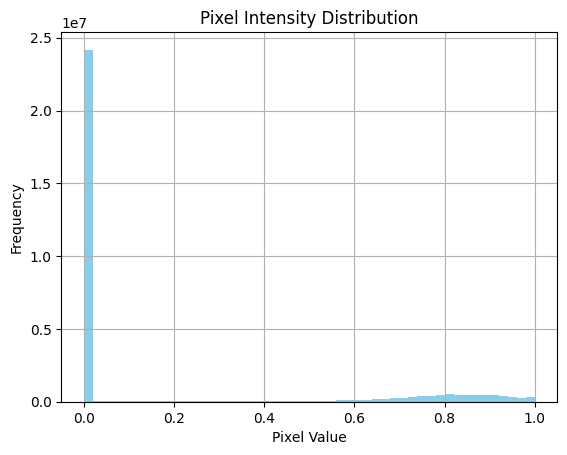

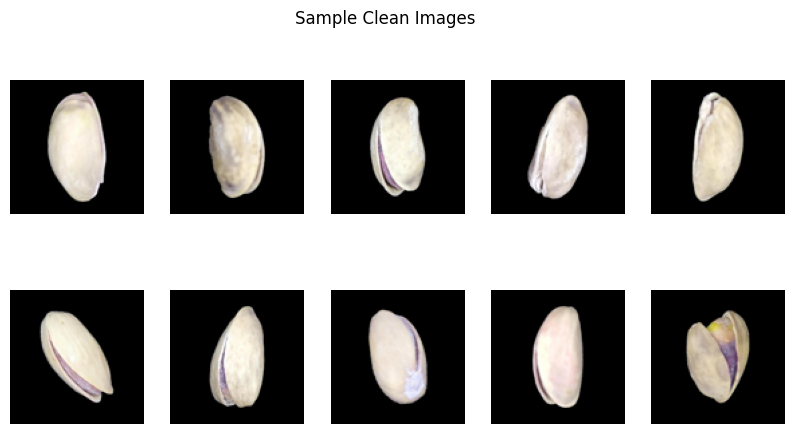

In [ ]:
import matplotlib.pyplot as plt

plt.hist(valid_images.ravel(), bins=50, color='skyblue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(valid_images[i])
    plt.axis('off')
plt.suptitle("Sample Clean Images")
plt.show()

distribusi intensitas piksel pada gambar-gambar tersebut. Dari grafik tersebut terlihat bahwa mayoritas piksel memiliki nilai intensitas yang sangat rendah (mendekati 0), yang menunjukkan bahwa sebagian besar area gambar berwarna hitam — kemungkinan merupakan latar belakang. Sedangkan nilai intensitas mendekati 1 yang muncul dalam jumlah lebih kecil mengindikasikan area biji pistachio yang terang.

Bagian bawah gambar memperlihatkan sampel dari gambar pistachio yang telah dibersihkan, dengan latar belakang hitam yang konsisten. Hal ini menunjukkan bahwa proses preprocessing seperti segmentasi atau masking telah dilakukan untuk memisahkan objek utama (pistachio) dari latar belakang, sehingga model dapat lebih fokus pada fitur penting dari objek tersebut selama pelatihan atau analisis lanjutan.

In [ ]:
print(f"Pixel Min: {valid_images.min():.4f}")
print(f"Pixel Max: {valid_images.max():.4f}")
print(f"Pixel Mean: {valid_images.mean():.4f}")
print(f"Pixel Std: {valid_images.std():.4f}")

Pixel Min: 0.0000
Pixel Max: 1.0000
Pixel Mean: 0.1900
Pixel Std: 0.3431


Pixel Min: 0.0000
Artinya, terdapat piksel dengan intensitas paling rendah, yaitu 0, yang menunjukkan warna hitam sempurna. Ini konsisten dengan latar belakang hitam pada gambar pistachio.

Pixel Max: 1.0000
Menunjukkan bahwa ada piksel dengan intensitas tertinggi, yaitu 1, yang berarti warna putih sempurna. Ini biasanya muncul pada bagian paling terang dari objek pistachio.

Pixel Mean: 0.1900
Rata-rata intensitas piksel berada di angka 0.19 (dalam skala 0–1), yang tergolong rendah. Ini mengindikasikan bahwa sebagian besar area gambar berwarna gelap — kembali mencerminkan dominasi latar belakang hitam.

Pixel Std: 0.3431
Nilai standar deviasi ini cukup besar untuk kisaran 0–1, yang menunjukkan bahwa ada variasi cukup besar dalam nilai piksel. Artinya, meskipun banyak area gelap, masih terdapat cukup banyak area terang (yaitu bagian biji pistachio), sehingga gambar memiliki kontras yang signifikan.

## Gaussian Noise

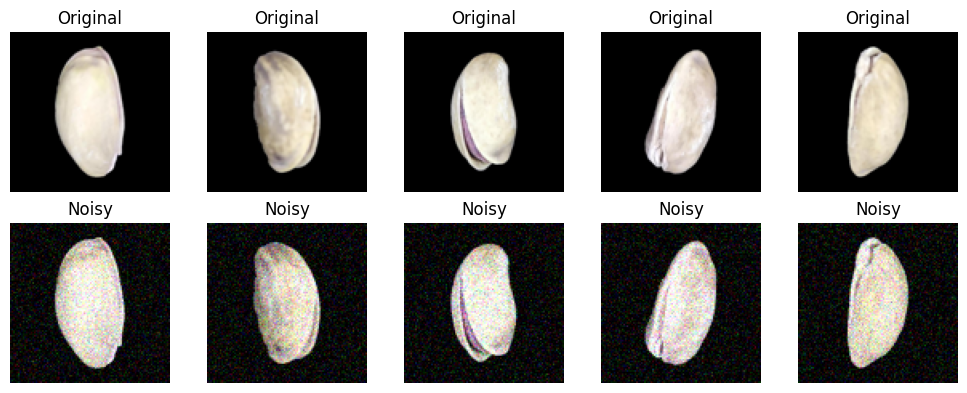

In [ ]:
# Gaussian noise (mean=0, std=0.1)
noise = np.random.normal(loc=0.0, scale=0.1, size=valid_images.shape)
noisy_images = np.clip(valid_images + noise, 0., 1.)

# Visualisasi
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(valid_images[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(noisy_images[i])
    plt.title("Noisy")
    plt.axis('off')
plt.tight_layout()
plt.show()

Baris atas (Original): 5 gambar pistachio asli dengan latar belakang hitam dan kualitas bersih.

Baris bawah (Noisy): Gambar yang sama namun telah diberi noise Gaussian, terlihat dari bintik-bintik acak atau “grainy effect” di seluruh gambar, termasuk latar belakang.

**Tujuan Gaussian**
- Augmentasi Data: Meningkatkan jumlah variasi dalam dataset agar model lebih robust dan tidak overfitting.

- Pengujian Model: Menguji sejauh mana model tetap akurat meskipun gambar mengandung gangguan atau noise.

- Simulasi Kondisi Nyata: Dalam dunia nyata, gambar bisa terkena noise karena kondisi pencahayaan atau kualitas sensor kamera.

# **Split Data**

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
x_train, x_temp, y_train, y_temp = train_test_split(noisy_images, valid_images, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Cek ukuran
print("Train set :", x_train.shape)
print("Val set   :", x_val.shape)
print("Test set  :", x_test.shape)

Train set : (859, 100, 100, 3)
Val set   : (107, 100, 100, 3)
Test set  : (108, 100, 100, 3)


# Autoencoder Baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
input_shape = (100, 100, 3)

In [ ]:
def build_autoencoder():
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(input_img, decoded)
    return model

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

## Training Baseline Model

In [ ]:
 history = autoencoder.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.1269 - val_loss: 0.0109
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.0113 - val_loss: 0.0093
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0073 - val_loss: 0.0033
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.0012 - val_lo

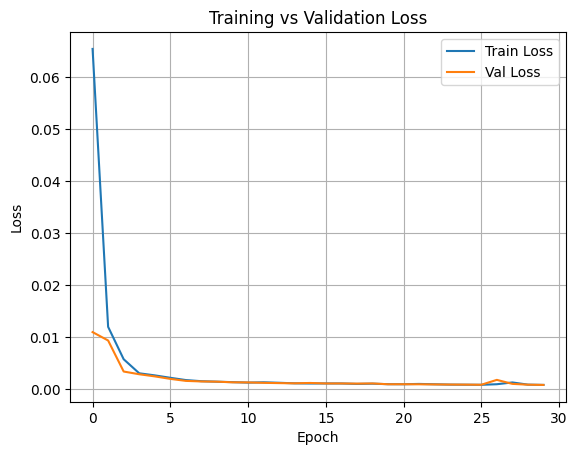

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


Grafik Training vs Validation Loss yang ditampilkan menunjukkan bahwa model autoencoder baseline yang dibangun telah mampu belajar dengan sangat baik dan cepat dalam merekonstruksi gambar.

 Pada awal training (epoch ke-1 hingga ke-3), terlihat adanya penurunan loss yang sangat tajam, dari sekitar 0.06 menjadi di bawah 0.01. Ini merupakan indikasi bahwa model dengan cepat menangkap fitur dasar dari gambar, seperti edge, warna, dan pola sederhana.

 Setelah epoch ke-3, baik training loss maupun validation loss menjadi stabil dan terus berada di kisaran yang sangat rendah, yaitu di bawah 0.005. Hal ini menunjukkan bahwa rekonstruksi gambar oleh model sangat mirip dengan gambar aslinya, dan noise berhasil diminimalkan dengan baik.

Selain itu, tidak terdapat perbedaan signifikan antara training loss dan validation loss, yang berarti model tidak mengalami overfitting—model tidak hanya belajar menghafal data training, tetapi juga mampu melakukan generalisasi dengan baik pada data validasi.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


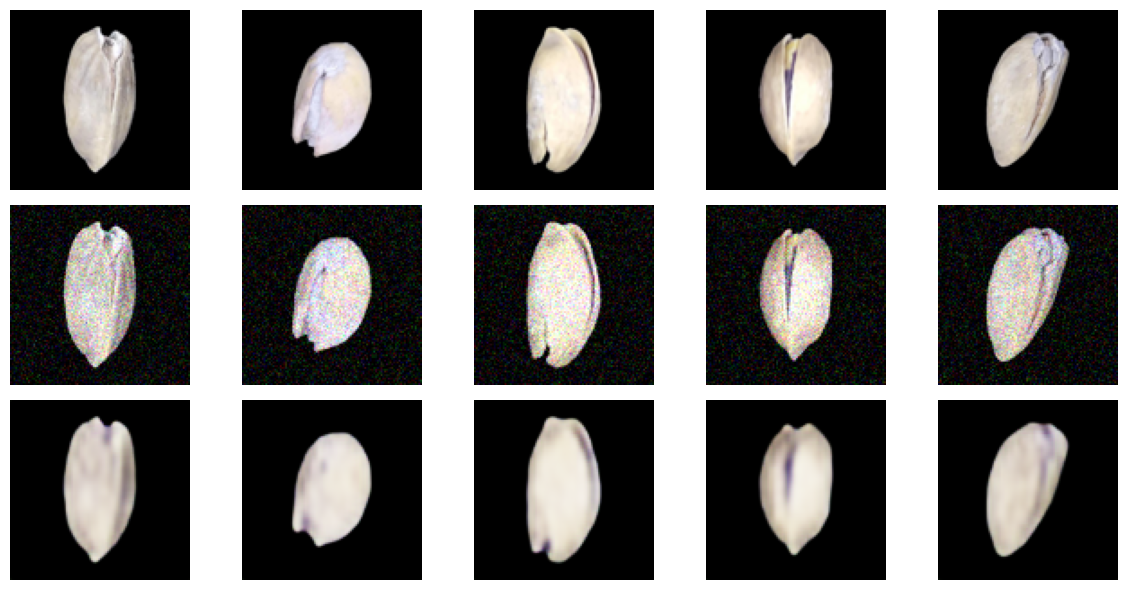

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

# Show original, noisy, and denoised images
n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    # Original
    plt.subplot(3, n, i + 1)
    plt.imshow(y_test[i])
    plt.axis('off')
    if i == 0: plt.ylabel("Original")

    # Noisy
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i])
    plt.axis('off')
    if i == 0: plt.ylabel("Noisy")

    # Denoised
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.axis('off')
    if i == 0: plt.ylabel("Denoised")

plt.tight_layout()
plt.show()


Autoencoder berhasil menjalankan fungsinya sebagai denoising model dengan cukup baik. Dari hasil rekonstruksi, terlihat bahwa:

- Noise berhasil dihilangkan secara signifikan, tanpa menyisakan banyak bintik acak.

- Struktur objek utama tetap terjaga, walaupun beberapa tekstur halus mengalami sedikit blur.

Model bekerja dengan baik untuk memulihkan citra biji dalam kondisi normal, namun mungkin perlu perbaikan jika ingin mempertahankan detail mikro yang lebih tajam.



# **Autoencoder Modification**

In [ ]:
from tensorflow.keras import layers, models

def build_modified_autoencoder():
    input_img = layers.Input(shape=(100, 100, 3))

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(input_img, output)
    return model

# Build dan compile
mod_autoencoder = build_modified_autoencoder()
mod_autoencoder.compile(optimizer='adam', loss='mse')
mod_autoencoder.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 50, 50, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 100, 100, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 100, 100, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 743,939 (2.84 MB)

 Trainable params: 742,659 (2.83 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Training Model Modification

In [ ]:
history_mod = mod_autoencoder.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val)
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 304s 11s/step - loss: 0.0607 - val_loss: 0.0457
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 316s 11s/step - loss: 0.0109 - val_loss: 0.0198
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 330s 11s/step - loss: 0.0060 - val_loss: 0.0301
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 327s 11s/step - loss: 0.0041 - val_loss: 0.0338
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step - loss: 0.0035 - val_loss: 0.0434
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step - loss: 0.0024 - val_loss: 0.0356
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 305s 11s/step - loss: 0.0036 - val_loss: 0.0330
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 323s 11s/step - loss: 0.0032 - val_loss: 0.0493
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - loss: 0.0024 - val_loss: 0.0414
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - loss: 0.0017 - val_loss: 0.0293
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 306s 11s/step - loss: 0.0020 - val_loss: 0.0177
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Prediksi model baseline & modifikasi
y_pred_baseline = autoencoder.predict(x_test)
y_pred_mod = mod_autoencoder.predict(x_test)

# SSIM untuk masing-masing model
def calculate_ssim(y_true, y_pred):
    scores = []
    for i in range(len(y_true)):
        score = ssim(y_true[i], y_pred[i], channel_axis=2, data_range=1.0)
        scores.append(score)
    return np.mean(scores)

ssim_baseline = calculate_ssim(y_test, y_pred_baseline)
ssim_mod = calculate_ssim(y_test, y_pred_mod)

print(f"Baseline SSIM: {ssim_baseline:.4f}")
print(f"Modified SSIM: {ssim_mod:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Baseline SSIM: 0.9518
Modified SSIM: 0.2993


- Model overparameterized → terlalu banyak filter sehingga overfitting atau tidak stabil.

- Training belum cukup lama → model belum sempat belajar baik.

- Aktivasi atau padding bermasalah .

- BatchNormalization tanpa Dropout → kadang bikin instabilitas jika data terbatas.

- Learning rate terlalu tinggi → menyebabkan model "tidak nyantol".



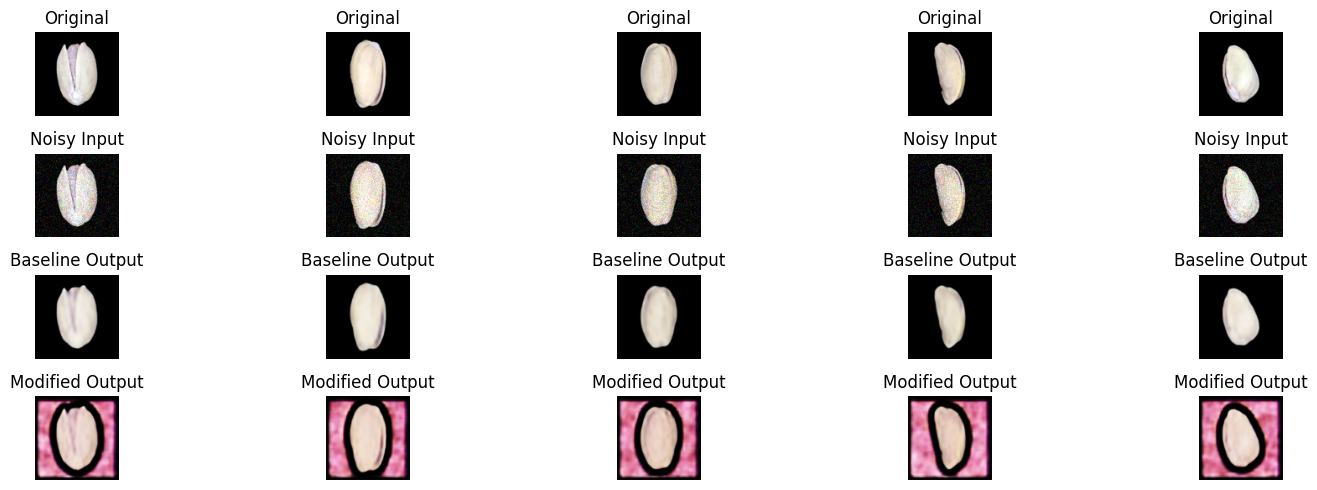

In [ ]:
import matplotlib.pyplot as plt

n = 5  # jumlah sampel yang ingin ditampilkan
indices = np.random.choice(len(x_test), n, replace=False)

plt.figure(figsize=(16, 5))
for i, idx in enumerate(indices):
    # Original (clean)
    plt.subplot(4, n, i + 1)
    plt.imshow(y_test[idx])
    plt.title("Original")
    plt.axis('off')

    # Noisy input
    plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test[idx])
    plt.title("Noisy Input")
    plt.axis('off')

    # Baseline output
    plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(y_pred_baseline[idx])
    plt.title("Baseline Output")
    plt.axis('off')

    # Modified output
    plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(y_pred_mod[idx])
    plt.title("Modified Output")
    plt.axis('off')

plt.tight_layout()
plt.show()


Gambar di atas menunjukkan hasil visualisasi perbandingan antara model autoencoder baseline dan model autoencoder yang telah dimodifikasi. Setiap kolom menampilkan satu sampel citra, dengan baris pertama menunjukkan gambar asli (tanpa noise), baris kedua adalah gambar yang telah diberi noise Gaussian (input ke model), baris ketiga adalah output dari model baseline, dan baris keempat adalah output dari model modifikasi.

Dari hasil tersebut terlihat bahwa model baseline mampu menghasilkan rekonstruksi yang cukup baik dan menyerupai gambar asli, meskipun terdapat sedikit kehilangan detail halus. Sementara itu, model modifikasi justru menghasilkan output yang tidak wajar — dengan latar belakang berwarna merah muda serta bentuk objek yang tidak utuh atau tampak terdistorsi. Hal ini menunjukkan bahwa meskipun arsitektur modifikasi memiliki kapasitas lebih besar, model tersebut gagal melakukan generalisasi, kemungkinan karena overfitting, distribusi noise yang tidak ditangani dengan baik, atau konfigurasi arsitektur yang tidak stabil (misalnya karena penggunaan BatchNormalization tanpa regularisasi tambahan seperti Dropout).

# Kesimpulan

Secara keseluruhan, visualisasi ini memperkuat hasil metrik SSIM sebelumnya, di mana model baseline menghasilkan nilai SSIM yang sedikit lebih baik, dan model modifikasi menghasilkan nilai yang rendah karena menghasilkan output yang jauh dari struktur visual asli gambar.